<a href="https://colab.research.google.com/github/Dzy00/CHL5230-Final-Project/blob/main/CHL5230_Final_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Decision Tree

1.   split data into 80% train, 20% test
2.   impute continuous variable with median, categorical with 0/or mode
3.   undersample major class with TomeKLinks
4.   Fit an initial model (step 2~4 are in pipeline)
5.   Tune hyperparameter using Grid search with cross validation
6.   Update model with the best hyperparameter
7.   Evaluate model performance

In [4]:
# CHL5230 final project C CHANGE dataset

!pip install category_encoders

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import scipy.stats as stats
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

import warnings
# warnings.filterwarnings('ignore')

# read the cleaned dataset, so we don't have to rerun the above exploratory and cleaned code
CHANGE_selected = pd.read_csv('CHANGE_selected.csv')


# Define the column that will be used as the target for modeling or analysis
target_column = 'MacroVasc'

# List of columns that contain categorical data
categorical_columns = ['Sex','Any_AntiHTN','HeartFailure_Hx','AtrialFibrillation_Hx',
                       'Smoking_Status','Hypertension_Hx','diabetes']

# List of columns that contain numerical data (excluding categorical columns and the target column)
numerical_columns = [c for c in CHANGE_selected.columns if c not in categorical_columns and c != target_column]




Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    288826
           1       0.06      0.71      0.10      3786

    accuracy                           0.84    292612
   macro avg       0.53      0.78      0.51    292612
weighted avg       0.98      0.84      0.90    292612



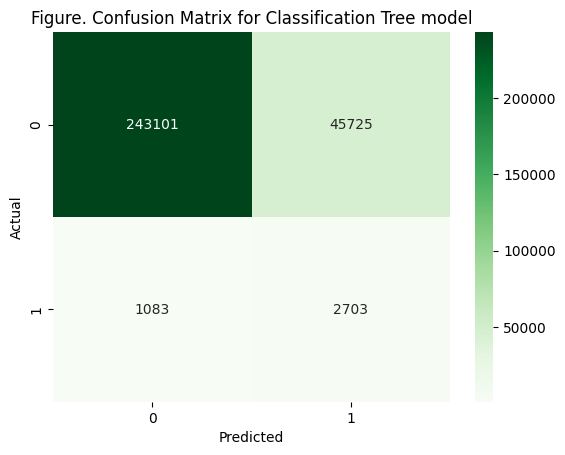

In [ ]:
########################################################## classification tree
# Splitting the data into 70% training and 30% testing
train = CHANGE_selected.sample(frac=0.7, random_state=10)
test = CHANGE_selected.drop(train.index)

# separate X, y
X_train = train.drop('MacroVasc', axis = 1)
y_train = train['MacroVasc']

# imputate numerical columns with median
num_transformer = SimpleImputer(strategy = 'median')

# impute categorical columns with the most frequent value and encode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    #('one_hot_encoder', OneHotEncoder())
    ])

# initialize a column transformer that handels imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
        ],
    remainder='passthrough')


##### model fitting
# Initializing a Decision Tree classifier
dt = tree.DecisionTreeClassifier(criterion='entropy',class_weight='balanced')

# Creating a pipeline that first preprocesses the data and then applies the decision tree
# this pipeline perform imputation, encoding, undersampling, and model fitting
model = Pipeline([
    ('preprocessor', preprocessor),
    #('tomek', TomekLinks()),
    ('under_sample', RandomUnderSampler(sampling_strategy=0.5)),
    ('up_sample', SMOTE(sampling_strategy=1)),
    ('DT', dt)
])

# Display the pipeline architecture
model

# Training the model on the training data
model = model.fit(X_train, y_train)

# Predicting and evaluating the model's performance on the training data
Y_pred = model.predict(X_train)
accuracy_score(y_train, Y_pred)

# Predicting and evaluating the model's performance on the test data
Y_pred = model.predict(test.drop('MacroVasc', axis=1))
accuracy_score(test['MacroVasc'], Y_pred)

# confusion matrix on test data
Y_test = test['MacroVasc']
conf_matrix_Tree = confusion_matrix(Y_test, Y_pred)
class_report_Tree = classification_report(Y_test, Y_pred)

print("\nClassification Report:")
print(class_report_Tree)

sns.heatmap(conf_matrix_Tree, cmap='Greens', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for Classification Tree model')
plt.show()



0.8700451110199777
0.8682487389444042

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    288826
           1       0.07      0.73      0.13      3786

    accuracy                           0.87    292612
   macro avg       0.53      0.80      0.53    292612
weighted avg       0.98      0.87      0.92    292612



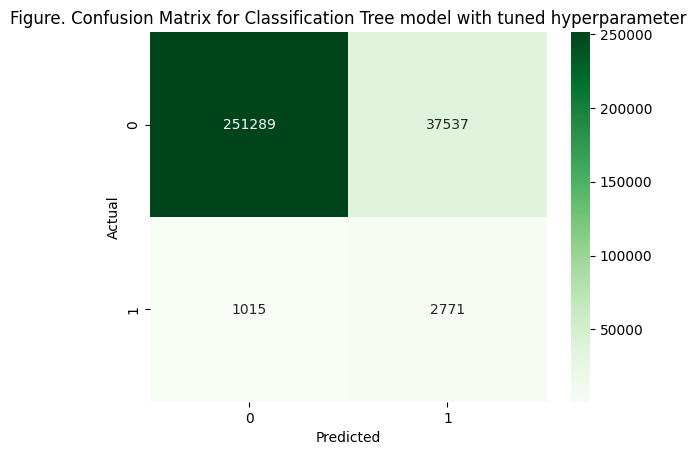

In [ ]:
### hyperparameter tuning using grid search
# Define the hyperparameter values that should be tested
param_dist = {
    "DT__max_depth" : [5, 10, 15, 20 ,25, 30, 35],
    "DT__min_samples_leaf" : [5, 10, 15, 20 ,25],
    "DT__splitter" : ['best', 'random'],
    "DT__max_features" : ['sqrt', 'log2']
}

# Setting up Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5)

# Initialize Grid Search with the model and the hyperparameters to search
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Train Grid Search on the training data
random_search.fit(X_train, y_train)

# Extract results into a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Display the set of parameters that achieved the best score
results[results['rank_test_score'] == 1]

# Retrieve the best hyperparameters after Grid Search
random_search.best_params_

##### fit classification tree with optimal hyperparameter
# Update the model's hyperparameters to the best found during Grid Search
model = model.set_params(**random_search.best_params_)

# Refit the model using the training data
model = model.fit(X_train, y_train)

# Make predictions on the training set and compute the accuracy
Y_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, Y_pred)
print(train_accuracy)

# Make predictions on the test set and compute the accuracy
Y_pred = model.predict(test.drop('MacroVasc', axis=1))
test_accuracy = accuracy_score(test['MacroVasc'], Y_pred)
print(test_accuracy)

# confusion matrix on test data
Y_test = test['MacroVasc']
conf_matrix_Tree = confusion_matrix(Y_test, Y_pred)
class_report_Tree = classification_report(Y_test, Y_pred)

print("\nClassification Report:")
print(class_report_Tree)

sns.heatmap(conf_matrix_Tree, cmap='Greens', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for Classification Tree model with tuned hyperparameter')
plt.show()


# Random Forest


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    288826
           1       0.07      0.81      0.13      3786

    accuracy                           0.86    292612
   macro avg       0.53      0.83      0.53    292612
weighted avg       0.99      0.86      0.91    292612



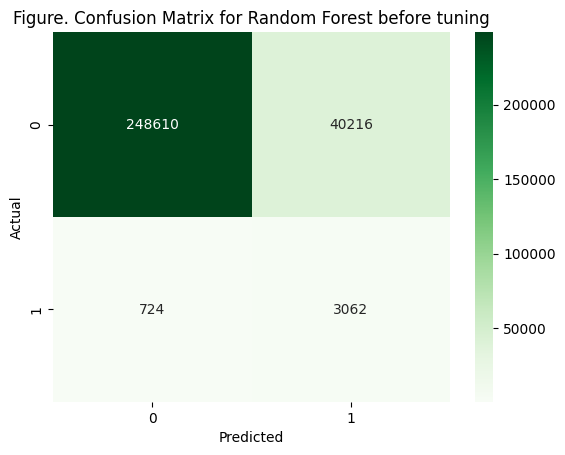

In [ ]:
# read the cleaned dataset
CHANGE_selected = pd.read_csv('CHANGE_selected.csv')


# Define the column that will be used as the target for modeling or analysis
target_column = 'MacroVasc'

# List of columns that contain categorical data
categorical_columns = ['Sex','Any_AntiHTN','HeartFailure_Hx','AtrialFibrillation_Hx',
                       'Smoking_Status','Hypertension_Hx','diabetes']

# List of columns that contain numerical data (excluding categorical columns and the target column)
numerical_columns = [c for c in CHANGE_selected.columns if c not in categorical_columns and c != target_column]


############################# random forest
# Splitting the data into 70% training and 30% testing
train = CHANGE_selected.sample(frac=0.7, random_state=10)
test = CHANGE_selected.drop(train.index)

# separate X, y
X_train = train.drop('MacroVasc', axis = 1)
y_train = train['MacroVasc']


# imputate numerical columns with median
num_transformer = SimpleImputer(strategy = 'median')

# impute categorical columns with the most frequent value and encode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    #('one_hot_encoder', OneHotEncoder())
    ])

# initialize a column transformer that handels imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
        ],
    remainder='passthrough')


##### Initialize a Random Forest classifier
# The criterion 'entropy' measures the quality of a split by how mixed the classes are in two groups
# class_weight 'balanced_subsample' is used to handle imbalanced classes. It computes weights based on the bootstrap sample for every tree grown.
# oob_score is set to True to use out-of-bag samples to estimate the generalization accuracy
random_forest = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', oob_score=True)

# Creating a pipeline that fits the Random Forest model
# this pipeline perform imputation, undersampling, and model fitting
model = Pipeline([
    ('preprocessor', preprocessor),
    #('tomek', TomekLinks()),
    ('under_sample', RandomUnderSampler(sampling_strategy=0.5)),
    ('up_sample', SMOTE(sampling_strategy=1)),
    ('random_forest', random_forest)
])

# Display the pipeline architecture
model

# Using the pipeline model to train on the training data.
model = model.fit(X_train, y_train)

# Predicting the target variable on the training set and evaluating the model's accuracy.
Y_pred = model.predict(X_train)
accuracy_score(y_train, Y_pred)

# Predicting the target variable on the test set and evaluating the model's accuracy.
Y_pred = model.predict(test.drop('MacroVasc', axis = 1))
accuracy_score(test['MacroVasc'], Y_pred)

# confusion matrix on test data before tuning
Y_test = test['MacroVasc']
conf_matrix_Tree = confusion_matrix(Y_test, Y_pred)
class_report_Tree = classification_report(Y_test, Y_pred)

print("\nClassification Report:")
print(class_report_Tree)

sns.heatmap(conf_matrix_Tree, cmap='Greens', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for Random Forest before tuning')
plt.show()





Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    288826
           1       0.07      0.81      0.14      3786

    accuracy                           0.87    292612
   macro avg       0.54      0.84      0.53    292612
weighted avg       0.99      0.87      0.92    292612



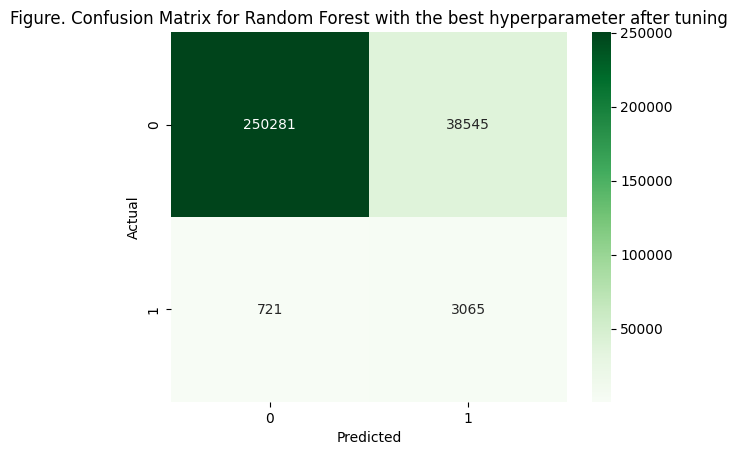

In [ ]:
##### hyperparameter tuning with grid search
# Setting hyperparameters for Random Forest for the Grid Search.
param_dist = {
    "random_forest__n_estimators" : [200],
    "random_forest__max_depth" : [5, 10, 15],
    "random_forest__min_samples_leaf" : [15, 20 ,25],
    "random_forest__max_features" : ['sqrt']
}

# Initializing stratified K-fold cross-validation. This ensures each fold has the same proportion of target labels as the whole dataset.
skf = StratifiedKFold(n_splits=5)

# Setting up GridSearchCV to search through the parameter space.
# It will evaluate the model for each combination of hyperparameters provided using stratified K-fold cross-validation.
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Running the GridSearchCV on the training data
random_search.fit(X_train, y_train)

# Extracting the results of the Grid Search into a DataFrame for analysis.
results = pd.DataFrame(random_search.cv_results_)

# Filtering to get the rows with the best performing hyperparameters.
results[results['rank_test_score'] == 1]

# Updating the model's hyperparameters with the best parameters identified from the Grid Search.
model = model.set_params(**random_search.best_params_)

# Retraining the model with the updated hyperparameters on the training data.
model = model.fit(X_train, y_train)

# Predicting the target variable on the training set and evaluating the model's accuracy.
Y_pred = model.predict(X_train)
accuracy_score(y_train, Y_pred)

# Predicting the target variable on the test set and evaluating the model's accuracy.
Y_pred = model.predict(test.drop('MacroVasc', axis = 1))
accuracy_score(test['MacroVasc'], Y_pred)

# confusion matrix on test data before tuning
Y_test = test['MacroVasc']
conf_matrix_forest = confusion_matrix(Y_test, Y_pred)
class_report_forest = classification_report(Y_test, Y_pred)

print("\nClassification Report:")
print(class_report_forest)

sns.heatmap(conf_matrix_forest, cmap='Greens', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for Random Forest with the best hyperparameter after tuning')
plt.show()


# XGBoost Classifier


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    288826
           1       0.07      0.78      0.14      3786

    accuracy                           0.87    292612
   macro avg       0.54      0.83      0.53    292612
weighted avg       0.98      0.87      0.92    292612



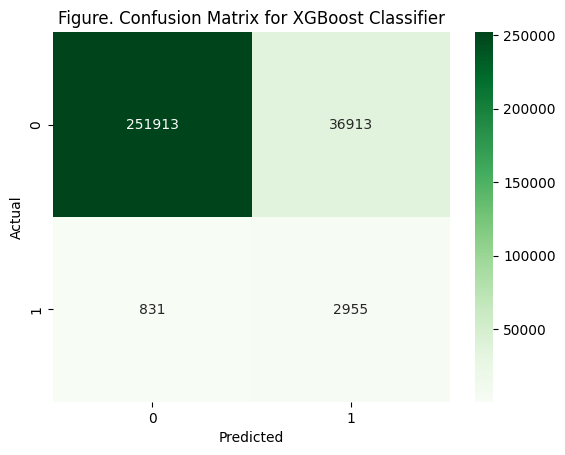

In [5]:
# read the cleaned dataset
CHANGE_selected = pd.read_csv('CHANGE_selected.csv')


# Define the column that will be used as the target for modeling or analysis
target_column = 'MacroVasc'

# List of columns that contain categorical data
categorical_columns = ['Sex','Any_AntiHTN','HeartFailure_Hx','AtrialFibrillation_Hx',
                       'Smoking_Status','Hypertension_Hx','diabetes']

# List of columns that contain numerical data (excluding categorical columns and the target column)
numerical_columns = [c for c in CHANGE_selected.columns if c not in categorical_columns and c != target_column]


######################################## XGBoost
# Splitting the data into 70% training and 30% testing
train = CHANGE_selected.sample(frac=0.7, random_state=10)
test = CHANGE_selected.drop(train.index)

# separate X, y
X_train = train.drop('MacroVasc', axis = 1)
y_train = train['MacroVasc']

# imputate numerical columns with median
num_transformer = SimpleImputer(strategy = 'median')

# impute categorical columns with the most frequent value and encode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    #('one_hot_encoder', OneHotEncoder())
    ])

# initialize a column transformer that handels imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
        ],
    remainder='passthrough')


# Initializing the Gradient Boosting Classifier with specified parameters
xg_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Creating a Pipeline: Gradient Boosting model
# impute, downsample, xg boost
model = Pipeline([
    ('preprocessor', preprocessor),
    #('tomek', TomekLinks()),
    ('under_sample', RandomUnderSampler(sampling_strategy=0.5)),
    ('up_sample', SMOTE(sampling_strategy=1)),
    ('xg_boost', xg_boost) # Training/prediction step: Using Gradient Boosting
])

# Display the pipeline architecture
model

# Training the Gradient Boosting model on the training dataset
model = model.fit(X_train, y_train)

# Predicting on the training dataset and computing the accuracy
Y_pred = model.predict(X_train)
accuracy_score(y_train, Y_pred)

# Predicting on the test dataset and computing the accuracy
Y_pred = model.predict(test.drop('MacroVasc', axis = 1))
accuracy_score(test['MacroVasc'], Y_pred)

# confusion matrix on test data before tuning
Y_test = test['MacroVasc']
conf_matrix_forest = confusion_matrix(Y_test, Y_pred)
class_report_forest = classification_report(Y_test, Y_pred)

print("\nClassification Report:")
print(class_report_forest)

sns.heatmap(conf_matrix_forest, cmap='Greens', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for XGBoost Classifier')
plt.show()




Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    288826
           1       0.08      0.80      0.15      3786

    accuracy                           0.89    292612
   macro avg       0.54      0.84      0.55    292612
weighted avg       0.99      0.89      0.93    292612



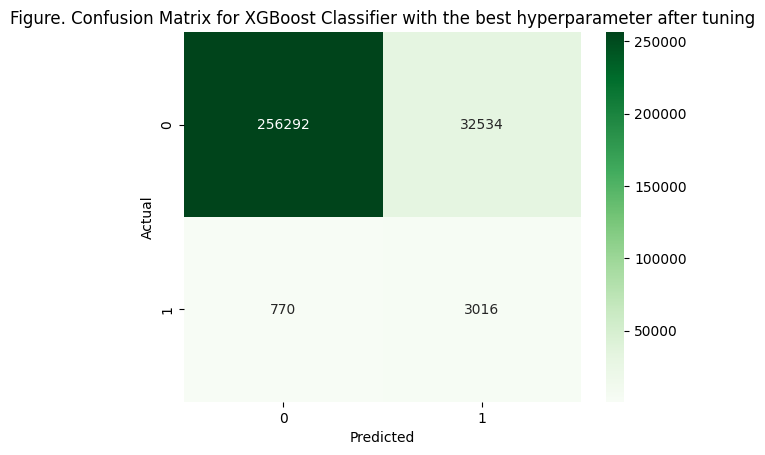

In [6]:
##### hyperparameter tuning
# Initializing the Gradient Boosting model with initial parameters
xg_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

# Creating a pipeline that first applies the column transformations, downsampling, and then runs the Gradient Boosting model
model = Pipeline([
    ('preprocessor', preprocessor),
    #('tomek', TomekLinks()),
    ('under_sample', RandomUnderSampler(sampling_strategy=0.5)),
    ('up_sample', SMOTE(sampling_strategy=1)),
    ('xg_boost', xg_boost) # Training/prediction step: Using Gradient Boosting
])

# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "xg_boost__n_estimators" : [100, 200],
    "xg_boost__max_depth" : [1, 5],
    "xg_boost__min_samples_leaf" : [25],
    "xg_boost__learning_rate" : [.1,  .2]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=5)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(
    model, param_grid=param_dist, cv=skf
)

# Fitting the GridSearchCV on the training data
random_search.fit(X_train, y_train)

# Storing and displaying the results of the grid search
results = pd.DataFrame(random_search.cv_results_)
results[results['rank_test_score'] == 1]

### model with the best hyperparameter
# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train, y_train)

# Predicting on the training dataset and computing the accuracy
Y_pred = model.predict(X_train)
accuracy_score(y_train, Y_pred)

# Predicting on the test dataset and computing the accuracy
Y_pred = model.predict(test.drop('MacroVasc', axis = 1))
accuracy_score(test['MacroVasc'], Y_pred)

# confusion matrix on test data before tuning
Y_test = test['MacroVasc']
conf_matrix_xgboost = confusion_matrix(Y_test, Y_pred)
class_report_xgboost = classification_report(Y_test, Y_pred)

print("\nClassification Report:")
print(class_report_xgboost)

sns.heatmap(conf_matrix_xgboost, cmap='Greens', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for XGBoost Classifier with the best hyperparameter after tuning')
plt.show()

